In [ ]:
import pandas as pd
import numpy as np

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

## column names for dataset
columns = [
    'status_sex', 'duration', 'credit_history', 'purpose', 'amount',
    'savings', 'employment_duration', 'installment_rate', 'personal_status_sex',
    'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans',
    'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'credit_risk'
]

df = pd.read_csv(url, sep=' ', names=columns)

# map the 'credit_risk' to 0 and 1 (1 = Good, 2 = Bad in original, so we convert)
df['credit_risk'] = df['credit_risk'].map({1: 0, 2: 1})

print("Dataset Loaded Successfully!")
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Loaded Successfully!
Dataset Shape: (1000, 21)


,status_sex,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


/tmp/ipython-input-1734103035.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='credit_risk', y='age', data=df, palette='viridis')


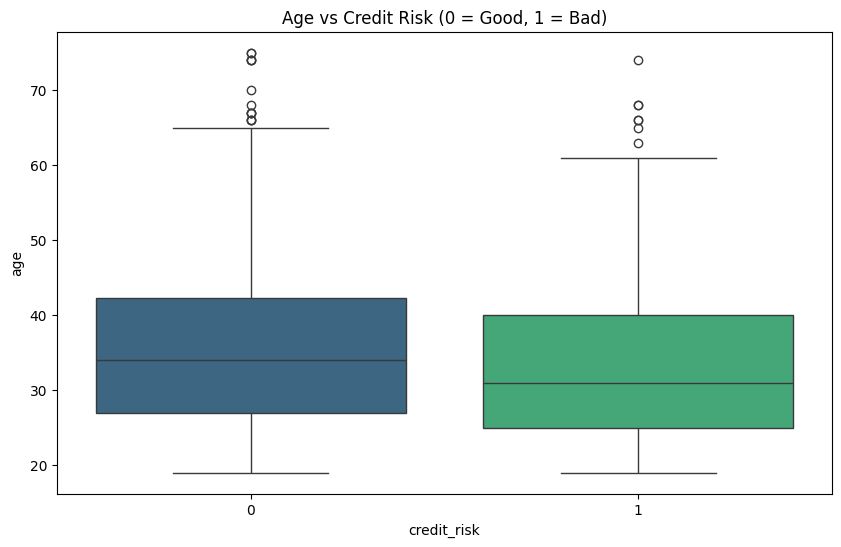

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='credit_risk', y='age', data=df, palette='viridis')
plt.title('Age vs Credit Risk (0 = Good, 1 = Bad)')
plt.show()

In [ ]:
## dataset had non-numerical columns so we need to convert this by encoding so the machine can read them

In [ ]:
!pip install shap -q

import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

## simple encoding for SHAP compatibility
## We'll use Label Encoding so the feature names stay clean for the plots
df_encoded = df.copy()
le = LabelEncoder()

for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = le.fit_transform(df_encoded[col])

## split into features (X) and target (y)
X = df_encoded.drop('credit_risk', axis=1)
y = df_encoded['credit_risk']

In [ ]:
## training the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

## Initialize SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
## create the explainer using the model we trained
explainer = shap.TreeExplainer(model)

## calculate SHAP values for the test set
## (we use [:, :, 1] because we want to explain the probability of 'Risk=1')
shap_values = explainer(X)

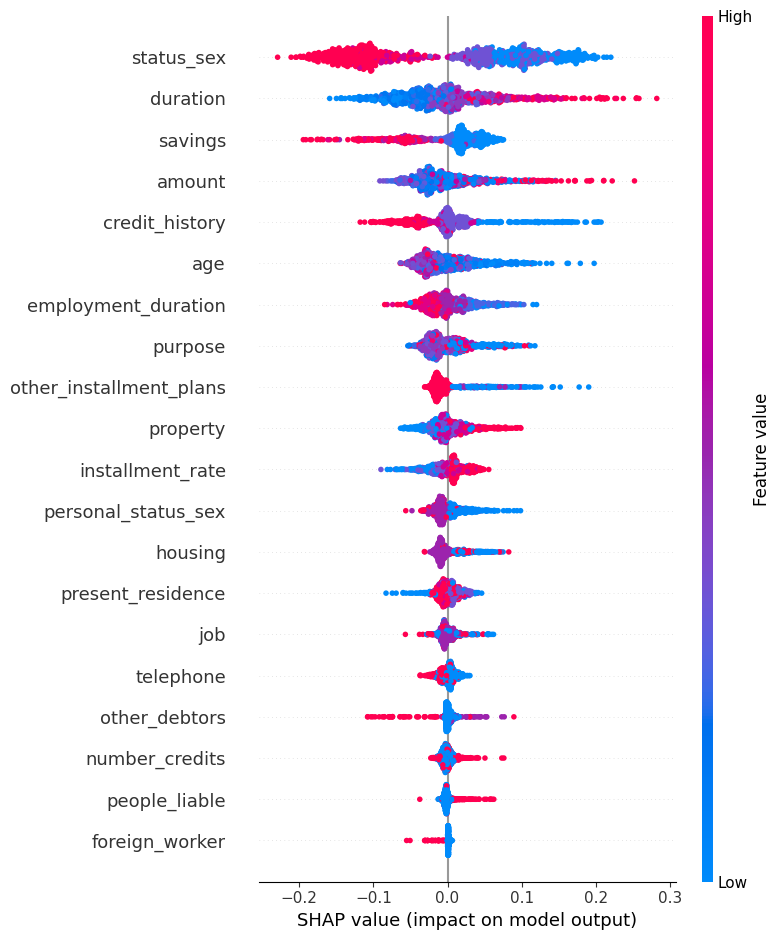

In [ ]:
## summary plot: shows feature importance and their impact direction
shap.summary_plot(shap_values[:, :, 1], X)

This summary plot shows the different features in the dataset in order of their importance and direction of impact. (positive SHAP values mean the feature increases the model's prediction, and negative SHAP values decrease it) Red dots indicate a higher value of that specific feature while blue dots indicate a lower value. For example, the summary plot shows that the feature 'duration' pushes the model to predict 'bad credit' if the duration increases, and pushes the model to predict 'good credit' if the duration decreases.

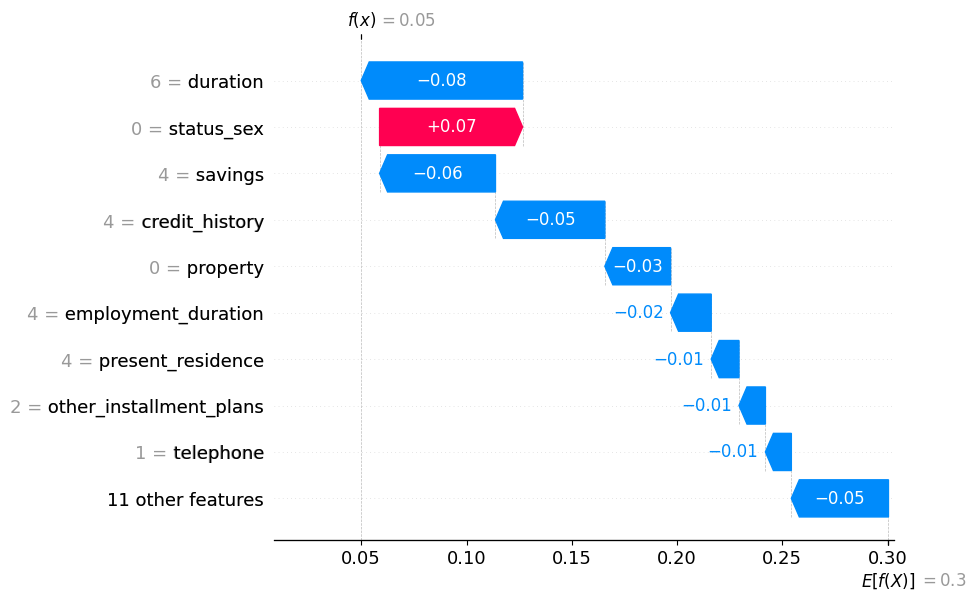

In [ ]:
# Explain the first applicant's prediction
# .base_values is the average prediction; .values is the contribution of each feature
shap.plots.waterfall(shap_values[0, :, 1])

As seen from the diagram above, the predicted probability of the first applicant having bad credit is 0.3. All features, except status_sex push the prediction lower towards 'good credit' as seen by the blue bars pointing left. Only status_sex pushes the prediction towards 'bad credit' as seen by the red bar pointing right.

In [ ]:
## using train-test split to ensure that there is no overlap between training data and test data

In [ ]:
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
# use 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (800, 20)
X_test shape: (200, 20)
y_train shape: (800,)
y_test shape: (200,)


Now, we need to retrain our Random Forest model using only the `X_train` and `y_train` data. After training, we will make predictions on the `X_test` data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Retrain the model on the training data
model_split = RandomForestClassifier(n_estimators=100, random_state=42)
model_split.fit(X_train, y_train)

# Make predictions on the test set
y_pred_split = model_split.predict(X_test)

print("Model retrained and predictions made on the test set.")

Model retrained and predictions made on the test set.


--- Credit Risk Model Report on Test Set ---
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       140
           1       0.70      0.43      0.54        60

    accuracy                           0.78       200
   macro avg       0.75      0.68      0.69       200
weighted avg       0.76      0.78      0.76       200



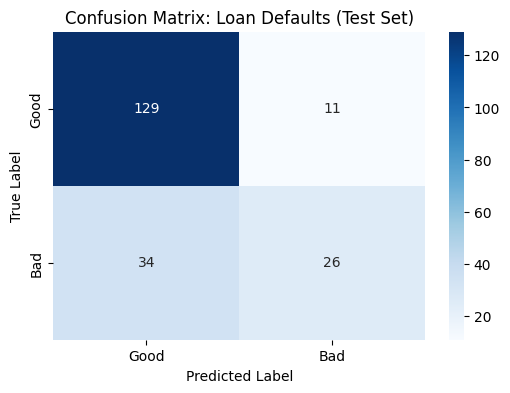

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Credit Risk Model Report on Test Set ---")
print(classification_report(y_test, y_pred_split))

# Confusion Matrix Visualization
cm_split = confusion_matrix(y_test, y_pred_split)
plt.figure(figsize=(6,4))
sns.heatmap(cm_split, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Loan Defaults (Test Set)')
plt.show()

By looking at the confusion matrix, one can see that the number of false negatives (34) is greater than the number of false positives (11). This suggests that the model is more likely to incorrectly approve a bad credit risk than to incorrectly deny a good one. Such mistakes are costly for the bank as it leads to giving credit to someone who will default.

# Bias and Fairness Checks

Models can be biased based on data sets. In order to ensure fairness, I checked if my model's false negatives rate (denying a good person a loan) is significantly higher for young applicants (<25 years old) than for older ones. For this data set, the main three are age, personal_status_sex and foreign_worker. I chose to focus on age for this project.

We will check for Disparate Impact. This is a metric that compares the "Approval Rate" for a protected group (young applicants) against a non-protected group (older applicants). A rule of thumb is that if the ratio of approval rate is < 0.8, the model is considered biased.

In [ ]:
# 1. Define the 'Young' group (under 25)
# Note: In the UCI dataset, Age is column index 12 or named 'age'
# We need to do this for the X_test subset, not the whole df_encoded
# Create a temporary DataFrame for fairness analysis on the test set
df_test_fairness = X_test.copy()
df_test_fairness['is_young'] = (df_test_fairness['age'] < 25).astype(int)

# 2. Calculate Approval Rates
# (Approval means the model predicted '0' for Good Credit)
# Add the predictions to the test fairness DataFrame
df_test_fairness['approved'] = (y_pred_split == 0).astype(int)

# 3. Compare Groups
stats = df_test_fairness.groupby('is_young')['approved'].mean()

print(f"Approval Rate for Older Applicants: {stats[0]:.2%}")
print(f"Approval Rate for Young Applicants: {stats[1]:.2%}")

# 4. Calculate Disparate Impact Ratio
di_ratio = stats[1] / stats[0]
print(f"\nDisparate Impact Ratio: {di_ratio:.2f}")

if di_ratio < 0.8:
    print("Model shows significant bias against young applicants.")
else:
    print("Model meets the 80% Fairness Rule")

Approval Rate for Older Applicants: 83.23%
Approval Rate for Young Applicants: 74.36%

Disparate Impact Ratio: 0.89
Model meets the 80% Fairness Rule


# Improving model performance

As seen from the confusion matrix above, the model predicts a higher number of false negatives than false negatives which leads to the bank incurring losses. The model performance can be improved by adjusting the prediction thresholds.

For classification models, predictions are often based on a probability score (predict_proba). A default threshold of 0.5 is usually applied as a cut-off to convert probabilities into a category. Since false negatives incur more losses for the bank, we can lower the threshold for classifying a credit risk as "bad".

In [ ]:
# Get predicted probabilities for the test set
y_pred_proba = model_split.predict_proba(X_test)[:, 1]  # Probabilities of class 1 (bad credit)

Now, let's define a function to evaluate the model with a custom threshold and see how it affects our key metrics, especially the false negatives and the confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_with_threshold(y_true, y_pred_proba, threshold):
    # Apply the new threshold to get binary predictions
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)

    print(f"\n--- Evaluation with Threshold: {threshold:.2f} ---")
    print(classification_report(y_true, y_pred_threshold))

    # Confusion Matrix Visualization
    cm_threshold = confusion_matrix(y_true, y_pred_threshold)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_threshold, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Threshold: {threshold:.2f})')
    plt.show()

    # Extract and print False Negatives for quick comparison
    tn, fp, fn, tp = cm_threshold.ravel()
    print(f"False Negatives (Actual Bad, Predicted Good): {fn}")
    print(f"False Positives (Actual Good, Predicted Bad): {fp}")
    return fn, fp

I evaluated the model with the original threshold (0.5) first, and then tried lower thresholds (e.g., 0.45 or 0.40) to see its impact on false negatives.


--- Original Model Performance (Threshold 0.5) ---

--- Evaluation with Threshold: 0.50 ---
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       140
           1       0.68      0.43      0.53        60

    accuracy                           0.77       200
   macro avg       0.74      0.67      0.69       200
weighted avg       0.76      0.77      0.75       200



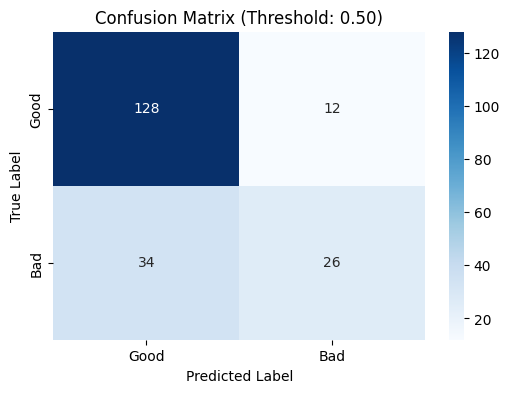

False Negatives (Actual Bad, Predicted Good): 34
False Positives (Actual Good, Predicted Bad): 12

--- Trying a Lower Threshold (0.45) ---

--- Evaluation with Threshold: 0.45 ---
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       140
           1       0.57      0.47      0.51        60

    accuracy                           0.73       200
   macro avg       0.68      0.66      0.67       200
weighted avg       0.72      0.73      0.73       200



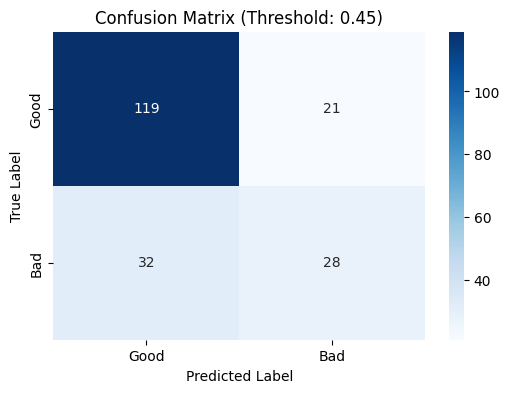

False Negatives (Actual Bad, Predicted Good): 32
False Positives (Actual Good, Predicted Bad): 21

--- Trying an Even Lower Threshold (0.40) ---

--- Evaluation with Threshold: 0.40 ---
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       140
           1       0.55      0.57      0.56        60

    accuracy                           0.73       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.73      0.73      0.73       200



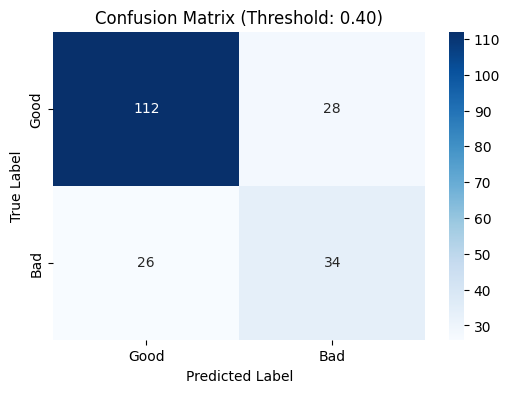

False Negatives (Actual Bad, Predicted Good): 26
False Positives (Actual Good, Predicted Bad): 28


In [ ]:
# Evaluate with original threshold (0.5)
print("\n--- Original Model Performance (Threshold 0.5) ---")
original_fn, original_fp = evaluate_with_threshold(y_test, y_pred_proba, threshold=0.5)

# Evaluate with a lower threshold, e.g., 0.45
print("\n--- Trying a Lower Threshold (0.45) ---")
new_fn_45, new_fp_45 = evaluate_with_threshold(y_test, y_pred_proba, threshold=0.45)

# Evaluate with an even lower threshold, e.g., 0.40
print("\n--- Trying an Even Lower Threshold (0.40) ---")
new_fn_40, new_fp_40 = evaluate_with_threshold(y_test, y_pred_proba, threshold=0.40)

After adjusting the threshold, the number of false negatives have decreased by 8 but there's a trade-off with an increase in false positives by 16. The bank would then have to decide if the cost saved from 8 fewer defaults outweighs the cost of rejecting 16 applicants with good credit risk.

On the other hand, the overall accuracy of the model has dropped from 78% to 73%, likely because the adjustment of the threshold has made the model more sensitive to predicting "bad credit". However, the model is still better off as it focuses on minimizing false negatives (accepting applicants who are likely to default), which has higher financial cost for the bank compared to financial cost of false positives (rejecting applicants with good credit).

# Deploying the model

In [ ]:
import joblib

# Save the retrained model
joblib.dump(model_split, 'random_forest_model.joblib')

print("Model 'random_forest_model.joblib' saved successfully!")

Model 'random_forest_model.joblib' saved successfully!


The next step is to save the individual LabelEncoders used for each categorical feature, which is crucial for preprocessing new, raw input data consistently with the trained model. I will first identify the categorical columns from the original dataframe and then save the fitted LabelEncoder for each of them.



In [ ]:
import joblib
from sklearn.preprocessing import LabelEncoder

# Re-initialize LabelEncoder for each categorical column and save them individually
# We need to map the column names to their corresponding LabelEncoder instances
# First, identify the categorical columns from the original df (before encoding)
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

# Create a dictionary to store fitted LabelEncoders
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on the original (un-encoded) column data
    le.fit(df[col])
    label_encoders[col] = le
    # Save each LabelEncoder
    joblib.dump(le, f'label_encoder_{col}.joblib')

print(f"Saved {len(categorical_cols)} LabelEncoders for categorical features.")


Saved 13 LabelEncoders for categorical features.


Now that the model and encoders are saved, the next step is to create a function that can load these assets, preprocess new raw input data using the loaded encoders, and then use the loaded model to make a prediction with the specified threshold. This function will be the core of the deployment.



In [ ]:
import joblib
import pandas as pd

def predict_credit_risk(input_data: pd.Series, threshold: float = 0.40):
    """
    Predicts credit risk for a single input using the saved model and encoders.

    Args:
        input_data (pd.Series): A single row of raw input data (e.g., from original df).
        threshold (float): The probability threshold to classify 'bad credit' (1).

    Returns:
        int: 0 for good credit, 1 for bad credit.
    """
    model = joblib.load('random_forest_model.joblib')

    # Identify categorical columns from the original dataset (excluding target 'credit_risk')
    global categorical_cols

    # Prepare a DataFrame for the single input for consistent processing
    # Drop 'credit_risk' if it's present, as it's the target
    processed_input = input_data.drop('credit_risk', errors='ignore').to_frame().T

    # Load and apply LabelEncoders for categorical columns
    for col in categorical_cols:
        if col in processed_input.columns:
            try:
                le = joblib.load(f'label_encoder_{col}.joblib')
                processed_input[col] = le.transform(processed_input[col])
            except Exception as e:
                print(f"Error transforming column {col}: {e}")
                pass

    # Make prediction (get probability of class 1 - bad credit)
    prediction_proba = model.predict_proba(processed_input)[:, 1][0]

    # Apply threshold
    prediction = 1 if prediction_proba >= threshold else 0

    return prediction, prediction_proba

print("Prediction function 'predict_credit_risk' defined.")


Prediction function 'predict_credit_risk' defined.


In [ ]:
# demonstrate functionality of the prediction function
import pandas as pd

# Take a sample input from the original dataframe
sample_input = df.iloc[0]

# Call the prediction function with the sample input and the chosen threshold
predicted_risk, probability = predict_credit_risk(sample_input, threshold=0.40)

print(f"Sample Input (first row of original df):\n{sample_input.to_dict()}")
print(f"\nPredicted Credit Risk (0=Good, 1=Bad) with threshold 0.40: {predicted_risk}")
print(f"Probability of Bad Credit: {probability:.4f}")

Sample Input (first row of original df):
{'status_sex': 'A11', 'duration': 6, 'credit_history': 'A34', 'purpose': 'A43', 'amount': 1169, 'savings': 'A65', 'employment_duration': 'A75', 'installment_rate': 4, 'personal_status_sex': 'A93', 'other_debtors': 'A101', 'present_residence': 4, 'property': 'A121', 'age': 67, 'other_installment_plans': 'A143', 'housing': 'A152', 'number_credits': 2, 'job': 'A173', 'people_liable': 1, 'telephone': 'A192', 'foreign_worker': 'A201', 'credit_risk': 0}

Predicted Credit Risk (0=Good, 1=Bad) with threshold 0.40: 0
Probability of Bad Credit: 0.0500
